In [1]:
# 统计一下PDBBind中PPI的蛋白分布情况
# 通过官方给的信息统计
import os
from Bio.PDB import PDBParser
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
ppi_data = pd.read_excel('./data/protein_protein/pp_affinity.xlsx',header=1,keep_default_na=False)
uniprot_ids = ppi_data['UniProt AC']
ppi_info = {}
protein_info = {}
for ids in uniprot_ids:
    id_list = str(ids).strip().split(' ')
    if str(ids) == '':
        continue
    if len(id_list) not in ppi_info:
        ppi_info[len(id_list)] = 1
    else:
        ppi_info[len(id_list)] += 1
    for prot_id in id_list:
        if prot_id not in protein_info:
            protein_info[prot_id] = 1
        else:
            protein_info[prot_id] += 1
print(ppi_info)
# print(sorted(protein_info.items(), key=lambda item: item[1], reverse=True))
protein_info = dict(sorted(protein_info.items(), key=lambda item: item[1], reverse=True))
json.dump(ppi_info, open('ppi_info_excel.json','w'))
json.dump(protein_info, open('protein_info_excel.json','w'))
# print(protein_info)
# 自己拆分pdb文件统计
root_dir = './data/PDBBind/PP/'
ppis = [i for i in os.listdir(root_dir) if i not in ['index', 'readme']]
p = PDBParser(QUIET=True)
protein_names = {}
ppi_info_from_pdb = {}
for ppi in tqdm(ppis):
    try:
        structure = p.get_structure(ppi[:-8],os.path.join(root_dir, ppi))
    except:
        print("Invalid structure")
        continue
    if len(structure) > 1:
        # print(f"Len of structure {ppi[:-8]} : {len(structure)}")
        continue
    model = structure[0]
    compound_info = structure.header['compound']
    protein_numbers = len(compound_info.items())
    if protein_numbers not in ppi_info_from_pdb:
        ppi_info_from_pdb[protein_numbers] = 1
    else:
        ppi_info_from_pdb[protein_numbers] += 1
    for key in compound_info:
        protein_id = compound_info[key]['molecule']
        if protein_id not in protein_names:
            protein_names[protein_id] = 1
        else:
            protein_names[protein_id] += 1
protein_names = dict(sorted(protein_names.items(), key=lambda item: item[1], reverse=True))
ppi_info_from_pdb = dict(sorted(ppi_info_from_pdb.items(), key=lambda item: item[1], reverse=True))
# print(protein_names)
print(ppi_info_from_pdb)
json.dump(protein_names, open('protein_info_pdb.json', 'w'))
json.dump(ppi_info_from_pdb, open('ppi_info_pdb.json', 'w'))
print("Done!")



{2: 1732, 4: 73, 3: 273, 1: 673, 5: 23, 7: 6, 6: 15, 9: 1, 13: 1, 16: 1, 8: 4, 14: 1}


100%|██████████| 2854/2854 [09:16<00:00,  5.13it/s]

Invalid structure
Invalid structure
{2: 1679, 3: 675, 4: 190, 5: 107, 6: 6, 1: 6, 9: 1, 13: 1, 16: 1, 7: 1, 14: 1}
Done!


{'2': 1732, '4': 73, '3': 273, '1': 673, '5': 23, '7': 6, '6': 15, '9': 1, '13': 1, '16': 1, '8': 4, '14': 1}


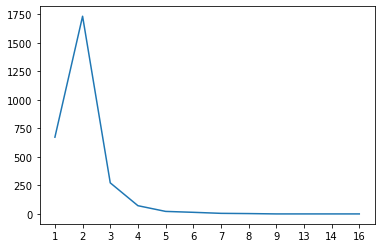

In [7]:
import json
import matplotlib.pyplot as plt
ppi_info_from_pdb = json.load(open('ppi_info_excel.json', 'r'))
xs = []
ys = []
print(ppi_info_from_pdb)
for i in dict(sorted(ppi_info_from_pdb.items(), key=lambda item: int(item[0]), reverse=False)):
    xs.append(i)
    ys.append(ppi_info_from_pdb[i])
plt.plot(xs,ys)
plt.show()

100%|██████████| 5316/5316 [04:25<00:00, 20.04it/s] 


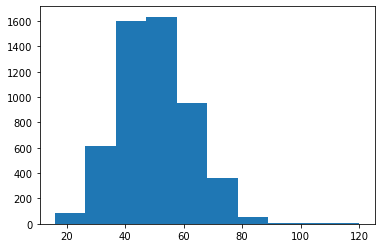

In [22]:
# 统计一下pocket包含的氨基酸个数，BioLip中包含的好少
import os
from Bio.PDB import PDBParser
from tqdm import tqdm
import matplotlib.pyplot as plt

root = './data/PDBBind/refined-set'
complexes = os.listdir(root)
complexes.remove('index')
complexes.remove('readme')
p = PDBParser(QUIET=True)
res_lens = []
for item in tqdm(complexes):
    pocket_dir = os.path.join(root, item, item+'_pocket.pdb')
    # print(pocket_dir)
    structure = p.get_structure(item, pocket_dir)
    model = structure[0]
    compound_info = structure.header['compound']
    # print(item)
    # print(compound_info)
    chains = model.get_chains()
    res_num = 0
    for chain in chains:
        # print("!", chain.get_id())
        residues = chain.get_residues()
        for residue in residues:
            if residue.get_resname() == 'HOH':
                continue
            res_num += 1    
    res_lens.append(res_num)
plt.hist(res_lens)
plt.show()

In [22]:
#搞搞QM9，看看数据样例
import os
from atom3d.datasets import LMDBDataset
import openbabel
from tqdm import tqdm
from rdkit import Chem
def converter(file_name):
    mols = [ mol for mol in Chem.SDMolSupplier( file_name ,sanitize=False) ]
    outname = file_name.split(".sdf")[0] + ".smi"
    # print("Len:", len(mols))
    for mol in mols:
        smi = Chem.MolToSmiles(mol)
        name = mol.GetProp("_Name")
        # print(smi)
    return smi
qm9_train = LMDBDataset('./data/random/data/train/')
# qm9_val = LMDBDataset('./data/random/data/val')
# qm9_test = LMDBDataset('./data/random/data/test/')
# print("Train, Val, Test Size:", len(qm9_train), len(qm9_val), len(qm9_test))  # Print QM9 length
qm9_smiles = []
# for i in tqdm(range(len(qm9_train))):
#     qm9_smiles.append(qm9_train[i]['smiles'])
#     # print(qm9_train[i]['smiles'])
#     print("Orig Smiles:", qm9_train[i]['smiles'])
#     mol = Chem.MolFromSmiles(qm9_train[i]['smiles'])
#     smiles = Chem.MolToSmiles(mol)
    # print("New Smiles:", smiles)
# for i in tqdm(range(len(qm9_val))):
#     qm9_smiles.append(qm9_val[i]['smiles'])
# for i in tqdm(range(len(qm9_test))):
#     qm9_smiles.append(qm9_test[i]['smiles'])

pdbbind_smiles = []
pdb_refined = os.listdir('./data/PDBBind/refined-set/')
for item in tqdm(pdb_refined):
    dir = os.path.join('./data/PDBBind/refined-set/', item, item+'_ligand.sdf')
    # print("DIR:", dir)
    smi = converter(dir)
    print(smi)
    mol = Chem.MolFromSmiles(smi)
    print(mol)
    smi = Chem.MolToSmiles(mol)
    # smi = Chem.RemoveHs(smi, sanitize=False)
    print(dir)
    print(smi)
# print(dataset[100001])  # Print 1st entry

  0%|          | 0/5318 [00:00<?, ?it/s]

[H]O[C@@]1([H])C([H])([H])[N@+]([H])(C([H])([H])C2:C([H]):N:C3:C(N([H])[H]):N:C([H]):N:C:2:3)C([H])([H])[C@]1([H])C([H])([H])C([H])([H])C([H])([H])[H]
None


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [1]:
#搞搞不同的数据集，看看都有些什么原子
import os
import re
from Bio.PDB import PDBParser, Selection
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from tqdm import tqdm
from atom3d.datasets import LMDBDataset

def count_atoms_pdb(item, file_dir):
    atom_list = []
    p = PDBParser(QUIET=True)
    try:
        structure = p.get_structure(item, file_dir)
        model = structure[0]
        chains = model.get_chains()
        pattern = re.compile(r'\d+H.')
        for chain in chains:
            # print("!", chain.get_id())
            residues = chain.get_residues()
            for residue in residues:
                if residue.get_resname() == 'HOH':
                    continue
                for atom in residue:
                    atom_id = atom.get_id()
                    if atom_id.startswith('H') or pattern.match(atom.get_id()) != None:
                        element = 'H'
                    elif atom_id[0:2] in ['CL', 'Cl']:
                        element = 'CL'
                    elif atom_id[0:2] == 'FE':
                        element = 'FE'
                    elif atom_id[0] in ['C','N','O','S','F','P']:
                        element = atom_id[0]
                    else:
                        element = atom_id
                    if element not in atom_list:
                        atom_list.append(element)
    except:
        return atom_list
    return atom_list

def count_atoms_mol(file_dir):
    atom_list = []
    mol = Chem.MolFromMol2File(file_dir)
    try:
        atoms = mol.GetAtoms()
    except:
        return atom_list
    # print(atoms)
    for atom in atoms:
        if atom.GetSymbol() not in atom_list:
            atom_list.append(atom.GetSymbol())
    return atom_list

# PDBBind_refined set:
def analyze_pdbbind_refined(root):
    complexes = os.listdir(root)
    complexes.remove('readme')
    complexes.remove('index')
    pdb_refined_atoms_protein = []
    pdb_refined_atoms_ligand = []
    for item in tqdm(complexes):
        # print(item)
        protein_dir = os.path.join(root, item, item+'_protein.pdb')
        mol_dir = os.path.join(root, item, item+'_ligand.mol2')
        protein_atoms = count_atoms_pdb(item, protein_dir)
        mol_atoms = count_atoms_mol(mol_dir)
        pdb_refined_atoms_protein = list(set(pdb_refined_atoms_protein + protein_atoms))
        pdb_refined_atoms_ligand = list(set(pdb_refined_atoms_ligand + mol_atoms))
    return pdb_refined_atoms_protein, pdb_refined_atoms_ligand

def analyze_pdbbind_pp(root):
    complexes = os.listdir(root)
    complexes.remove('readme')
    complexes.remove('index')
    complexes.remove('ppi_cache_interface.pkl')
    complexes.remove('ppi_cache.pkl')
    complexes = [os.path.join(root, i) for i in os.listdir(root)]
    atom_list = []
    atom_list = analyze_protein_dataset(complexes, atom_list)
    return atom_list

def analyze_protein_dataset(complexes, atom_list):
    # EC or GO dataset analysis
    for complex in tqdm(complexes):
        protein_atoms = count_atoms_pdb(os.path.split(complex)[-1],complex)
        atom_list = list(set(atom_list + protein_atoms))
    return atom_list

def analyze_ec_go(root_dir):
    train_dir = os.path.join(root_dir, 'train')
    val_dir = os.path.join(root_dir, 'valid')
    test_dir = os.path.join(root_dir, 'test')
    complexes_train = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
    complexes_val = [os.path.join(val_dir, i) for i in os.listdir(val_dir)]
    complexes_test = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
    atom_list = []
    atom_list = analyze_protein_dataset(complexes_train, atom_list)
    atom_list = analyze_protein_dataset(complexes_val, atom_list)
    atom_list = analyze_protein_dataset(complexes_test, atom_list)
    return atom_list

def analyze_molecule_lmdb(root_dir, atom_list):
    qm9 = LMDBDataset(root_dir)
    for i in tqdm(range(len(qm9))):
        # print(qm9[i])
        elements = list(qm9[i]['atoms']['element'])
        atom_list = list(set(atom_list + elements))
    return atom_list

def analyze_qm9(root_dir):
    train_dir = os.path.join(root_dir, 'train')
    val_dir = os.path.join(root_dir, 'val')
    test_dir = os.path.join(root_dir, 'test')
    atom_list = []
    atom_list = analyze_molecule_lmdb(train_dir, atom_list)
    atom_list = analyze_molecule_lmdb(val_dir, atom_list)
    atom_list = analyze_molecule_lmdb(test_dir, atom_list)
    return atom_list
    
root = './data/random/data/'
atom_list_qm9 = analyze_qm9(root)
print("Atoms in QM9:", atom_list_qm9)

root = './data/PDBBind/refined-set/'
pdb_refined_atoms_protein, pdb_refined_atoms_ligand = analyze_pdbbind_refined(root)
print("Protein atoms in PDBBind refined set:", pdb_refined_atoms_protein)
print("Ligand atoms in PDBBind refined set:", pdb_refined_atoms_ligand)

root = './data/PDBBind/PP'
atom_list_pp = analyze_pdbbind_pp(root)
print("Atoms in PDBBind PP:", atom_list_pp)
     
root = './data/EnzymeCommission'
atom_list_ec = analyze_ec_go(root)
print("Atoms in EnzymeCommission:", atom_list_ec)

root = './data/GeneOntology'
atom_list_go = analyze_ec_go(root)
print("Atoms in GeneOntology:", atom_list_go)



/home-new/rhan21/anaconda3/envs/eqgat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 12943/12943 [00:17<00:00, 741.68it/s]


Atoms in QM9: ['O', 'N', 'F', 'C', 'H']


100%|██████████| 5316/5316 [08:33<00:00, 10.36it/s]


Protein atoms in PDBBind refined set: ['O', 'N', 'ZN', 'C', 'MG', 'H', 'K', 'MN', 'P', 'FE', 'S', 'LI']
Ligand atoms in PDBBind refined set: ['O', 'N', 'Cl', 'F', 'C', 'Br', 'P', 'I', 'S']


100%|██████████| 2856/2856 [09:11<00:00,  5.18it/s]


Atoms in PDBBind PP: ['AS', 'F', 'MOM1', 'H', 'K', 'I', 'CL', 'AU', 'UNK', 'V1', 'V2', 'BR', 'C', 'V8', 'AL', 'V6', 'I27', 'V5', 'Y1', 'O', 'N', 'BA', 'Y', 'V7', 'ZN', 'MG', 'MO', 'P', 'I01', 'S', 'U', 'B', 'V4', 'V10', 'V9', 'VG', 'MN', 'V3', 'FE']


100%|██████████| 1919/1919 [01:18<00:00, 24.33it/s]


Atoms in EnzymeCommission: ['DG', 'BR17', 'F', 'MO2', 'MN3', 'B29', 'DE21', 'W6', 'MOM1', 'BR9', 'DM2', 'I23', 'I', 'LU', 'W2', 'D2', 'UNK', 'W11', 'BR6', 'DD21', 'W3', 'C', 'YB', 'D152', 'DM1', 'BR15', 'D', 'BN1', 'DO1', 'DZ3', 'TA2', 'W8', 'O', 'B1', 'I8', 'ER', 'UNL', 'DM3', 'TA1', 'I3', 'D51', 'D12A', 'DE22', 'I1', 'D4', 'DO2', 'B45', 'GD', 'VG', 'MN4', 'MO1', 'D322', 'B26', 'DB', 'I2', 'DG1', 'W10', 'D32', 'IE', 'BR27', 'DH21', 'D321', 'H', 'K', 'BR21', 'MN1', 'DD1', 'BR', 'V2', 'DE', 'W', 'BR7', 'BR19', 'AL', 'BR2', 'D1', 'B7', 'DH12', 'LA', 'TA5', 'DE2', 'I01', 'MN2', 'DD2', 'B', 'EU', 'D12', 'V3', 'BRA', 'BR14', 'W9', 'BR5', 'B3', 'RE', 'D31', 'B12', 'BRB', 'DH', 'BR1', 'CL', 'AU', 'DD', 'BR3', 'V1', 'DH11', 'D151', 'MG1', 'B13', 'MO7', 'B2', 'MO5', 'BRAD', 'Y', 'ZN', 'MG', 'DE1', 'D11', 'MO', 'RB', 'D52', 'TA4', 'BR18', 'S', 'I54', 'DH22', 'TA3', 'BR4', 'TB', 'DC', 'V4', 'MO4', 'D13', 'XE', 'BRC', 'FE', 'AS', 'BR13', 'TA6', 'BE', 'W7', 'RU', 'W12', 'D43', 'W1', 'D3', 'I4', 'DD

100%|██████████| 3415/3415 [02:22<00:00, 23.98it/s]

Atoms in GeneOntology: ['DG', 'BR17', 'D27', 'D37', 'F', 'MO2', 'BR9', 'DE21', 'B29', 'MOM1', 'W6', 'MN3', 'DM2', 'I23', 'I', 'D30', 'LU', 'D2', 'W2', 'UNK', 'W11', 'MO8', 'BR6', 'DD21', 'W3', 'C', 'D152', 'DM1', 'YB', 'BR15', 'D', 'BN1', 'X', 'DZ3', 'TA2', 'W8', 'O', 'B1', 'BRE', 'BZ', 'RU1', 'UNL', 'ER', 'I8', 'DM3', 'TA1', 'I3', 'D51', 'DE22', 'I1', 'D4', 'D26', 'DO2', 'VG', 'GD', 'MN4', 'MO1', 'DB', 'I2', 'DG1', 'W10', 'D32', 'IE', 'BR27', 'DH21', 'K', 'H', 'BR21', 'MN1', 'DD1', 'BR', 'V2', 'DE', 'W', 'BR7', 'BR19', 'DN1', 'AL', 'BR2', 'D1', 'BRD', 'DH12', 'LA', 'TA5', 'DE2', 'W16', 'I01', 'MN2', 'I5', 'DD2', 'B', 'EU', 'D42', 'D12', 'W18', 'D41', 'V3', 'BRA', 'TE1', 'BR14', 'W9', 'BR5', 'IR1', 'D29', 'RE', 'D31', 'B12', 'BRAC', 'BRB', 'DH', 'CL', 'BR1', 'AU', 'BR3', 'DE12', 'V1', 'DH11', 'D151', 'MG1', 'DD', 'B13', 'MO7', 'B2', 'MO5', 'BRAD', 'Y', 'DE11', 'ZN', "I3'", 'MG', 'DE1', 'D11', 'MO', 'RB', 'D52', 'TA4', 'BR18', 'S', 'DH22', 'TA3', 'I54', 'BR4', "I5'", 'TB', 'W13', 'V4', 

In [1]:
#Test
import time
import torch
a = [1,2,3]
b = []
c = torch.tensor(a+b, dtype=torch.long)
c = c.to('cuda')
c = 0
count = 0
while True:
    time.sleep(0.1)
    count += 1
    if count == 100:
        break
print(c)

/home-new/rhan21/anaconda3/envs/eqgat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0


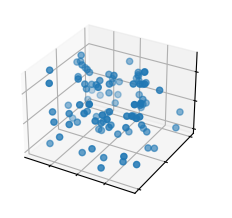

In [32]:
# matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# Make data
np.random.seed(19680801)
n = 100
rng = np.random.default_rng()
xs = rng.uniform(23, 32, n)
ys = rng.uniform(0, 100, n)
zs = rng.uniform(-50, -25, n)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

In [23]:
# 尝试一下radius_graph
import torch
from torch_cluster import radius_graph

x = torch.tensor([[-1., -1.], [-1., 1.], [1., -1.], [1., 1.]])
batch = torch.tensor([0, 0, 0, 0])
edge_index = radius_graph(x, r=2.1, batch=batch, loop=False, max_num_neighbors=1)
print(edge_index)
# 感觉很奇怪

tensor([[1, 0, 0, 1, 2],
        [0, 1, 2, 3, 3]])


In [31]:
# 尝试一下embedding
import torch.nn as nn
import numpy as np
filed_dims = [10, 20, 30, 40]
class embedding_model(nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        '''
        (0, *np.cumsum(field_dims)[:-1]得到的是
        (0, 用户index, 用户index+物品index, 用户index+物品index+A特征index)
        例如上面提到的
		offsets=[0, 10, 10+20, 10+20+30]=[0, 10, 30, 60]
        '''
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
    def forward(self, x):
        '''
            new_tensor()可以将原张量中的数据复制到目标张量（数据不共享），同时提供了更细致的属性控制
        '''
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)
    
x = torch.tensor([[4,6,16,31],[3,3,3,3]])
model = embedding_model(field_dims=filed_dims, embed_dim=15)
y = model(x)
print(y.shape)

torch.Size([2, 4, 15])


/tmp/ipykernel_2850041/3288428290.py:15: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)


In [35]:
#搞搞EnzymeCommission的annotation，看看数据情况
import pandas as pd
label_dir = './data/EnzymeCommission/nrPDB-EC_annot.tsv'
with open(label_dir, 'r') as f:
    lines = f.readlines()
labels = lines[1].strip().split('\t')
label_dict = {}
pdb_annot_dict = {}
label_id = 0
for label in labels:
    if label not in label_dict:
        label_dict[label] = label_id
        label_id += 1
print(label_dict)
print(labels)
for item in lines[3:]:
    pdb_id, annotations = item.split('\t')
    annotations_list = annotations.strip().split(',')
    pdb_annot_dict[pdb_id] = [label_dict[annot] for annot in annotations_list]
print(pdb_annot_dict)
# 一共有538类，是一个multi-label的二分类问题

{'1.4.3.-': 0, '4.2.1.1': 1, '2.7.6.-': 2, '3.5.1.88': 3, '5.4.99.-': 4, '3.1.21.4': 5, '2.3.1.48': 6, '7.2.1.-': 7, '1.16.3.1': 8, '3.4.19.12': 9, '1.3.8.-': 10, '2.7.7.19': 11, '2.4.2.-': 12, '1.1.1.169': 13, '2.4.2.10': 14, '3.5.3.1': 15, '3.3.2.-': 16, '3.1.26.4': 17, '7.1.1.9': 18, '3.4.13.9': 19, '1.1.1.100': 20, '5.1.1.-': 21, '3.1.22.-': 22, '3.4.21.-': 23, '1.11.1.-': 24, '3.4.22.28': 25, '4.6.1.18': 26, '3.4.21.4': 27, '6.1.1.4': 28, '1.15.1.1': 29, '3.4.19.-': 30, '3.4.11.1': 31, '3.4.25.1': 32, '1.3.1.9': 33, '2.4.99.-': 34, '1.1.99.-': 35, '1.97.1.12': 36, '2.7.4.6': 37, '1.17.1.-': 38, '1.7.2.-': 39, '2.7.1.71': 40, '4.2.1.11': 41, '3.4.21.90': 42, '4.1.99.-': 43, '2.8.1.1': 44, '3.6.4.13': 45, '6.3.4.4': 46, '2.7.11.1': 47, '2.7.7.23': 48, '1.9.3.-': 49, '2.3.1.39': 50, '4.1.1.11': 51, '3.2.1.26': 52, '3.1.13.-': 53, '1.8.99.-': 54, '1.11.1.6': 55, '4.2.1.2': 56, '5.3.4.1': 57, '3.2.1.4': 58, '3.4.21.5': 59, '1.14.16.-': 60, '6.3.4.2': 61, '2.1.1.37': 62, '1.12.99.-': 63

In [ ]:
#继续看看EC的结构情况
import os
import re
import pickle
from tqdm import tqdm
from Bio.PDB import PDBParser
p = PDBParser(QUIET=True)
nmr_files = []
files = os.listdir('./data/EnzymeCommission/train/')
complexes = []
cache_dir = os.path.join('./data/EnzymeCommission/', 'ec_cache_train.pkl')
if os.path.exists(cache_dir):
    print("Start loading cached EC files...")
    processed_complexes = pickle.load(open(cache_dir, 'rb'))
    print("Dataset size:", len(processed_complexes))
else:
    print("Cache not found! Start processing EC files...")
    for item in tqdm(files):
        structure = p.get_structure(item[:-8],os.path.join('./data/EnzymeCommission/train', item))
        model = structure[0]
        chains_info = []
        names_info = []
        chains = list(model.get_chains())
        if len(chains) != 1:
            print("Found an abnormal structure, containing ", len(chains), " chains")
            continue
        pattern = re.compile(r'\d+H.')
        processed_complex = {'complex_id': item.split('_')[0], 'labels':[],
                            'atoms_protein': [], 'protein_seq': []}
        elements = []
        xs = []
        ys = []
        zs = []
        chain_ids = []
        protein_seq = []
        chain = chains[0]
        for residue in chain.get_residues():
            # 删除HOH原子
            # if remove_hoh and residue.get_resname() == 'HOH':
            #     continue
            protein_seq.append(residue.get_resname())
            for atom in residue:
                # 删除氢原子
                # if self.remove_hydrogen and atom.get_id().startswith('H') or pattern.match(atom.get_id()) != None:
                #     continue
                elements.append(atom.get_id())
                chain_ids.append(chain.id)
                x, y, z = atom.get_vector()
                xs.append(x)
                ys.append(y)
                zs.append(z)
        protein_df = pd.DataFrame({'chain': chain_ids, 'element': elements, 'x': xs, 'y': ys, 'z': zs})
        processed_complex['atoms_protein'].append(protein_df)
        processed_complex['protein_seq'].append(protein_seq)
        print(processed_complex)
        complexes.append(processed_complex)

In [5]:
#搞搞数据，看看单个蛋白dimer的是什么情况
import os
from Bio.PDB import PDBParser
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
root_dir = './data/PDBBind/PP/'
ppis = [i for i in os.listdir(root_dir) if (i not in ['index', 'readme'] and not i.endswith('pkl'))]
p = PDBParser(QUIET=True)
protein_names = {}
ppi_info_from_pdb = {}
for ppi in tqdm(ppis):
    structure = p.get_structure(ppi[:-8],os.path.join(root_dir, ppi))
    if len(structure) > 1:
        # print(f"Len of structure {ppi[:-8]} : {len(structure)}")
        continue
    model = structure[0]
    compound_info = structure.header['compound']
    protein_numbers = len(compound_info.items())
    if protein_numbers == 1:
        print(ppi, compound_info)
    if protein_numbers not in ppi_info_from_pdb:
        ppi_info_from_pdb[protein_numbers] = 1
    else:
        ppi_info_from_pdb[protein_numbers] += 1
    for key in compound_info:
        protein_id = compound_info[key]['molecule']
        if protein_id not in protein_names:
            protein_names[protein_id] = 1
        else:
            protein_names[protein_id] += 1
protein_names = dict(sorted(protein_names.items(), key=lambda item: item[1], reverse=True))
ppi_info_from_pdb = dict(sorted(ppi_info_from_pdb.items(), key=lambda item: item[1], reverse=True))
print(ppi_info_from_pdb)
json.dump(protein_names, open('protein_info_pdb.json', 'w'))
json.dump(ppi_info_from_pdb, open('ppi_info_pdb.json', 'w'))
print("Done!")



  5%|▍         | 135/2854 [00:33<07:47,  5.81it/s]

4u97.ent.pdb {'1': {'misc': '', 'molecule': 'interleukin-1 receptor-associated kinase 4', 'chain': 'a, b', 'synonym': 'irak-4,renal carcinoma antigen ny-ren-64', 'ec_number': '2.7.11.1', 'ec': '2.7.11.1', 'engineered': 'yes', 'mutation': 'yes'}}


  5%|▌         | 150/2854 [00:35<05:10,  8.71it/s]

3v1c.ent.pdb {'1': {'misc': '', 'molecule': 'computational design, mid1-zinc', 'chain': 'a, b', 'synonym': 'computational redesign of the biological sequence.', 'engineered': 'yes'}}


 40%|████      | 1147/2854 [16:38<18:29,  1.54it/s] 

6b6u.ent.pdb {'1': {'misc': '', 'molecule': 'pyruvate kinase pkm', 'chain': 'a, b', 'synonym': 'cytosolic thyroid hormone-binding protein,cthbp,opa-interacting protein 3,oip-3,pyruvate kinase 2/3,pyruvate kinase muscle isozyme,thyroid hormone-binding protein 1,thbp1,tumor m2-pk, p58 ', 'ec_number': '2.7.1.40', 'ec': '2.7.1.40', 'engineered': 'yes', 'mutation': 'yes'}}


 77%|███████▋  | 2206/2854 [25:54<07:36,  1.42it/s]  


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [7]:
import torch
import torch.nn as nn
@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        m.weight.fill_(1.0)
        print(m.weight)
net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

In [3]:
import torch
from torch_scatter import scatter
s = torch.tensor([1,2,3,4,5,6,7,8,9,10])
batch = torch.tensor([0,0,0,0,0,0,0,1,1,1])
y_pred = scatter(s, index=batch, dim=0, reduce='mean')
print(y_pred)

tensor([4, 9])


In [ ]:
#试试读取自己的pdb文件
import atom3d
from atom3d.datasets import PDBDataset
import Bio.PDB.Structure
import atom3d.util.formats as fo
import pandas as pd
atoms = fo.bp_to_df(fo.read_any('./1ugx/1ugx.pdb'))
# print(fo.read_any('./data/PDBBind/PP/1a2k.ent.pdb').get_chains())
# print(atoms)
atoms.to_excel('./output.xlsx')


In [108]:
#手动分离完整的PDB complex
#自己使用biopython，看看能不能把两个蛋白分开
import json
from Bio.PDB import PDBParser
import re
p = PDBParser(QUIET=True)
#先看一个demo的pdb文件里面的头
    # structure = p.get_structure('7sue','./7SUE.pdb')
    # headers = structure.header.keys
    # print(headers)
    # model = structure[0]
    # print(model)
    # chains = list(model.get_chains())
    # print(chains)
    # residues = list(chains[1].get_residues())
    # print(residues)
    # print(structure.header['compound'])
    # print(model) 
#再验证一下PDBBind里的protein和ligand的文件是否可以手动分开
structure_demo = p.get_structure('1a1e','./1a1e/1A1E.pdb')
model = structure_demo[0]
compound_info = structure_demo.header['compound']
print(compound_info)
chains_info = []
names_info = []
for key_id in compound_info:
    chains_info.append(compound_info[key_id]['chain'])
    names_info.append(compound_info[key_id]['molecule'])
# print(chains_info, names_info)
chains = list(model.get_chains())
pattern = re.compile(r'\d+H.')
complex_info_dict = {}
for i, name in enumerate(names_info):
    complex_info_dict[name] = {}
    complex_info_dict[name]['atoms'] = []
    complex_info_dict[name]['residues'] = []
    complex_info_dict[name]['coordinates'] = []
    for chain in chains:
        if chain.id == ' ':
            print('We don\'t care about this chain: ', chain)
            continue
        if chain.id.lower() in chains_info[i]:
            for residue in chain.get_residues():
                if residue.get_resname() == 'HOH':
                    continue
                complex_info_dict[name]['residues'].append(residue.get_resname())
                for atom in residue:
                    if atom.get_id().startswith('H') or pattern.match(atom.get_id()) != None:
                        continue
                    complex_info_dict[name]['atoms'].append(atom.get_id())
                    x, y, z = atom.get_vector()
                    complex_info_dict[name]['coordinates'].append([x, y, z])
# print(complex_info_dict)
json.dump(complex_info_dict,open('1a1e_complex.json', 'w'))
print('protein residue numbers:', len(complex_info_dict['c-src tyrosine kinase']['residues']))
print('protein atom numbers: ', len(complex_info_dict['c-src tyrosine kinase']['atoms']))


{'1': {'misc': '', 'molecule': 'c-src tyrosine kinase', 'chain': 'a, b', 'fragment': 'sh2 domain', 'ec_number': '2.7.1.112', 'ec': '2.7.1.112', 'engineered': 'yes'}, '2': {'misc': '', 'molecule': 'ace-phosphotyr-glu-(3-butylpiperidine)', 'chain': 'c, d', 'engineered': 'yes'}}
protein residue numbers: 208
protein atom numbers:  1639
[57.90399932861328, 24.527000427246094, 16.45800018310547]
[36.13399887084961, 33.01100158691406, 22.527999877929688]
0
[56.6349983215332, 24.23900032043457, 17.11400032043457]
[35.917999267578125, 33.11399841308594, 23.540000915527344]
1
[56.571998596191406, 24.562000274658203, 18.604999542236328]
[37.09600067138672, 32.63199996948242, 22.413999557495117]
2
[55.46900177001953, 24.718000411987305, 19.110000610351562]
[36.06800079345703, 33.93899917602539, 22.062000274658203]
3
[56.29800033569336, 22.729000091552734, 16.822999954223633]
[35.15999984741211, 32.07899856567383, 21.909000396728516]
4
[54.80099868774414, 22.586000442504883, 16.88800048828125]
[35.

IndexError: list index out of range

In [146]:
#和PDBBind分离的对比一下
from Bio.PDB import PDBParser
from decimal import Decimal
import decimal
import re
p = PDBParser(QUIET=True)
name = '1ugx'
structure_demo = p.get_structure(name,f'./{name}/{name}_protein.pdb')
model = structure_demo[0]

chains = list(model.get_chains())
print(chains)
complex_info_dict = {}
complex_info_dict[name] = {}
complex_info_dict[name]['atoms'] = []
complex_info_dict[name]['residues'] = []
complex_info_dict[name]['coordinates'] = []
pattern = re.compile(r'\d+H.')
for chain in chains:
    # print(chain.id)
    # if chain.id == ' ':
    #     print('We don\'t care about this chain: ', chain)
    #     continue
    for residue in chain.get_residues():
        # print(residue)
        complex_info_dict[name]['residues'].append(residue.get_resname())
        for atom in residue:
            # if atom.get_id().startswith('H') or pattern.match(atom.get_id()) != None:
            #     continue
            complex_info_dict[name]['atoms'].append(atom.get_id())
            x, y, z = atom.get_vector()
            # x = Decimal(x).quantize(Decimal('0.0000'), rounding=decimal.ROUND_HALF_UP)
            # y = Decimal(y).quantize(Decimal('0.0000'), rounding=decimal.ROUND_HALF_UP)
            # z = Decimal(z).quantize(Decimal('0.0000'), rounding=decimal.ROUND_HALF_UP)
            complex_info_dict[name]['coordinates'].append([float(x), float(y), float(z)])
json.dump(complex_info_dict,open('1ugx_protein.json', 'w'))
print('protein residue numbers:', len(complex_info_dict[name]['residues']))
print('protein atom numbers: ', len(complex_info_dict[name]['atoms']))

[<Chain id=A>, <Chain id=B>, <Chain id=C>, <Chain id=D>, <Chain id=E>, <Chain id=F>, <Chain id=G>, <Chain id=H>, <Chain id= >]
protein residue numbers: 1072
protein atom numbers:  9512


In [124]:
#试试处理好的pth文件读取
import torch
# from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from experiments.lba.data import CustomLBADataset
data = torch.load('../lba/data/train/data_0.pth')
def train_dataloader(shuffle: bool = True):
    dataset = CustomLBADataset(root='../lba/data/',split="train")
    # print(dataset[0])
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True
    )
dataloader = train_dataloader()
print(data)
print(data.x.shape)
print(data.y)
atoms = []
positions = []
lig_count = (data.lig_flag == 1).sum()
for i, item in enumerate(data.x):
    if data.lig_flag[i] == 0:
        atoms.append(item.item())
for i, pos in enumerate(data.pos):
    if data.lig_flag[i] == 0:
        positions.append([pos[0].item(), pos[1].item(), pos[2].item()])
print(len(atoms))
print(atoms)
print(len(positions))
print(lig_count)
# for index, item in enumerate(dataloader):
#     # print(item)
#     print(item.num_graphs)

Data(x=[331], edge_index=[2, 7981], pos=[331, 3], edge_weights=[7981], y=[1], lig_flag=[331], prot_id='1ugx', smiles='COC1OC(CO)C(O)C(OC2OC(CO)C(O)C(O)C2O)C1NC(C)=O')
torch.Size([331])
tensor([5.9100])
304
[2, 0, 0, 0, 1, 0, 0, 1, 3, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 3, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 3, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0, 2, 0, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 3, 0, 2, 0, 1, 0, 1, 3, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 3, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 3, 3, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0

Positions: tensor([[36.1340, 33.0110, 22.5280],
        [35.9180, 33.1140, 23.5400],
        [37.0960, 32.6320, 22.4140],
        [36.0680, 33.9390, 22.0620],
        [35.1600, 32.0790, 21.9090],
        [35.2310, 31.1130, 22.4090],
        [34.1560, 32.4820, 22.0410],
        [35.4170, 31.8830, 20.4290],
        [36.3580, 32.4530, 19.8720],
        [34.5820, 31.0740, 19.7890],
        [33.8110, 30.6170, 20.3170],
        [34.7210, 30.8120, 18.3640],
        [35.7660, 30.9320, 18.0780],
        [33.8570, 31.7950, 17.5860],
        [32.6400, 31.8050, 17.7250],
        [34.2820, 29.3850, 18.0460],
        [34.8690, 28.7020, 18.6600],
        [33.2270, 29.2860, 18.3030],
        [34.4570, 28.9900, 16.5940],
        [33.8790, 29.6680, 15.9660],
        [35.5120, 29.0600, 16.3280],
        [33.9770, 27.5640, 16.3650],
        [34.5880, 26.8850, 16.9600],
        [32.9360, 27.4860, 16.6800],
        [34.0810, 27.1680, 14.9030],
        [35.1210, 27.2480, 14.5860],
        [33.4680, 27.8440, 

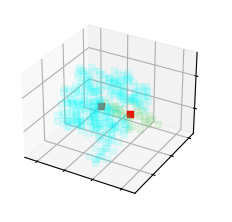

Train Set: 3507
Val Set: 466
Test Set: 490
Total: 4463


In [62]:
#试试没处理好的mdb文件
import pandas as pd
import torch
import importlib
import experiments.utils as utils
# from experiments.utils import prot_graph_transform
importlib.reload(utils)
from atom3d.datasets import LMDBDataset
from typing import Dict
from torch_geometric.data import Data, Dataset
# matplotlib
import matplotlib.pyplot as plt
import numpy as np

class GNNTransformLBA(object):
    def __init__(
        self,
        cutoff: float = 4.5,
        remove_hydrogens: bool = False,
        pocket_only: bool = True,
        max_num_neighbors: int = 32,
    ):
        self.pocket_only = pocket_only
        self.cutoff = cutoff
        self.remove_hydrogens = remove_hydrogens
        self.max_num_neighbors = max_num_neighbors

    def __call__(self, item: Dict) -> Data:
        # print(item.keys())
        # print(item)
        item['atoms_protein'].to_excel('demo_protein.xlsx')
        item['atoms_ligand'].to_excel('demo_ligand.xlsx')
        ligand_df = item["atoms_ligand"]
        if self.pocket_only:
            protein_df = item["atoms_pocket"]
        else:
            protein_df = item["atoms_protein"]

        atom_df = pd.concat([protein_df, ligand_df], axis=0)

        if self.remove_hydrogens:
            # remove hydrogens
            atom_df = atom_df[atom_df.element != "H"].reset_index(drop=True)

        labels = item["scores"]
        lig_flag = torch.zeros(atom_df.shape[0], dtype=torch.int)
        lig_flag[-len(ligand_df):] = 1
        # print("Lig Flag:", lig_flag)
        graph = utils.prot_graph_transform(
            atom_df=atom_df, cutoff=self.cutoff, max_num_neighbors=self.max_num_neighbors,flag=lig_flag, super_node=True
        )
        graph.y = torch.FloatTensor([labels["neglog_aff"]])

        graph.lig_flag = lig_flag

        graph.prot_id = item["id"]
        graph.smiles = item["smiles"]

        return graph

transform = GNNTransformLBA(
    cutoff=4.5,
    remove_hydrogens=False,
    pocket_only=True,
)
train_dataset = LMDBDataset('../lba/data/split-by-sequence-identity-30/data/train', transform=transform)
val_dataset = LMDBDataset('../lba/data/split-by-sequence-identity-30/data/val', transform=transform)
test_dataset = LMDBDataset('../lba/data/split-by-sequence-identity-30/data/test', transform=transform)
a = train_dataset[0]
atoms = []
positions = []
lig_count = (a.lig_flag == 1).sum()
prot_positions = []
for i, item in enumerate(a.x[:-2]):
    if a.lig_flag[i] == 0:
        atoms.append(item.item())
for i, pos in enumerate(a.pos[:-2]):
    if a.lig_flag[i] == 0:
        positions.append([pos[0].item(), pos[1].item(), pos[2].item()])
    else:
        prot_positions.append([pos[0].item(), pos[1].item(), pos[2].item()])


positions = torch.tensor(positions)
prot_positions = torch.tensor(prot_positions)

plt.style.use('_mpl-gallery')

# Make data
print("Positions:", a.pos)
xs, ys, zs = positions[:,0], positions[:,1], positions[:,2]
prot_xs, prot_ys, prot_zs = prot_positions[:,0], prot_positions[:,1], prot_positions[:,2]
super_xs, super_ys, super_zs = a.pos[-2:,0], a.pos[-2:,1], a.pos[-2:,2]
# # Plot
# print(xs.shape, ys.shape, zs.shape)
# print(prot_xs.shape, prot_ys.shape, prot_zs.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs, marker=',', alpha=0.1, color='cyan')
ax.scatter(prot_xs, prot_ys, prot_zs, marker=',', alpha=0.1, color='limegreen')
ax.scatter(super_xs, super_ys, super_zs, color='r', marker='s', alpha=1)
ax.set(xticklabels=[],
    yticklabels=[],
    zticklabels=[])
plt.savefig('atom_cloud.jpg',dpi=600)
plt.show()

print("Train Set:", len(train_dataset))
print("Val Set:", len(val_dataset))
print("Test Set:", len(test_dataset))
print("Total:", len(train_dataset) + len(val_dataset) + len(test_dataset))
 

In [83]:
# 测试一下转换line graph
# TODO: 转成Line Graph
from typing import List
def generate_line_graph(pos: torch.Tensor, edge_index: torch.Tensor, super_idx: List[int]):
    source_dict = {}
    new_pos = []
    new_edge_index = []
    #为新的“边节点”编号
    idx_dict = {}
    #将原有的普通边转换成节点, 并且构造一个source-to-target字典
    current_idx = 0
    for edge in edge_index.transpose(0,1):
        source, target = edge
        source = source.item()
        target = target.item()
        # 这里的转换不包括super node
        if source not in super_idx and target not in super_idx:
            idx = str(source) + '_' + str(target)
            idx_dict[idx] = current_idx
            current_idx += 1
            new_postion = (pos[edge[0]] + pos[edge[1]]) / 2
            new_pos.append(new_postion)
        # 这里完整记录所有边
        if source not in source_dict:
            source_dict[source] = [target] 
        else:
            source_dict[source].append(target)
    # 给两个super node添加规定的位置，并添加一个新的超级点
    new_pos = new_pos + [pos[super_idx[0]], pos[super_idx[1]], (pos[super_idx[0]] + pos[super_idx[1]]) / 2]
    # 需要给他们编下号
    idx_dict['s1'] = current_idx
    idx_dict['s2'] = current_idx + 1
    idx_dict['ss'] = current_idx + 2
    # 开始给新的“边节点”连线
    print("Idx dict:", idx_dict)
    print("Source dict:", source_dict)
    for edge in edge_index.transpose(0,1):
        source, target = edge
        source = source.item()
        target = target.item()
        if target in source_dict:
            next_targets = source_dict[target]
        else:
            continue
        
        if source in super_idx and target in super_idx:
            if source == super_idx[0]:
                new_edge_index.append([idx_dict['s1'], idx_dict['ss']])
                new_edge_index.append([idx_dict['ss'], idx_dict['s2']])
            else:
                new_edge_index.append([idx_dict['ss'], idx_dict['s1']])
                new_edge_index.append([idx_dict['s2'], idx_dict['ss']])
        elif source in super_idx:
            for next_target in next_targets:
                if target != source:
                    if source == super_idx[0]:
                        source_idx = idx_dict['s1']
                    else:
                        source_idx = idx_dict['s2']
                    if next_target not in super_idx:
                        target_idx = idx_dict[str(target) + '_' + str(next_target)]
                    else:
                        continue
                new_edge_index.append([source_idx, target_idx])
        elif target in super_idx:
            continue
        else: 
            for next_target in next_targets:
                source_idx = idx_dict[str(source) + '_' + str(target)]
                if next_target not in super_idx:
                    target_idx = idx_dict[str(target) + '_' + str(next_target)]
                elif next_target == super_idx[0]:
                    target_idx = idx_dict['s1']
                elif next_target == super_idx[1]:
                    target_idx = idx_dict['s2']
                new_edge_index.append([source_idx, target_idx])
    # 添加完了，打印出来看看
    new_pos = torch.stack(new_pos, dim=0)
    # new_edge_index = torch.cat(new_edge_index, dim=0)
    # new_pos = torch.tensor(new_pos)
    new_edge_index = torch.tensor(new_edge_index)
    print("Printing...:", new_pos.shape)
    print("Printing...:", new_edge_index.transpose(0,1))
    return new_pos, new_edge_index


pos = torch.tensor([[-1,1,0], [1,1,0], [1,-1,0], [2,1,0], [3,1,0], [3,-1,0], [1/3,1/3,0], [8/3, 1/3,0]])
edge_idx = torch.tensor([[0,1], [1,2], [4,3], [4,5] ,[6,0], [0,6], [6,1], [1,6], [6,2], [2,6], [7,3],[3,7], [7,4],[4,7],[7,5], [5,7], [6,7], [7,6]]).transpose(0,1)
super_nodes = [6,7]
_, _ = generate_line_graph(pos,edge_idx,super_nodes)



Idx dict: {'0_1': 0, '1_2': 1, '4_3': 2, '4_5': 3, 's1': 4, 's2': 5, 'ss': 6}
Source dict: {0: [1, 6], 1: [2, 6], 4: [3, 5, 7], 6: [0, 1, 2, 7], 2: [6], 7: [3, 4, 5, 6], 3: [7], 5: [7]}
Printing...: torch.Size([7, 3])
Printing...: tensor([[0, 0, 1, 2, 3, 4, 4, 5, 5, 4, 6, 6, 5],
        [1, 4, 4, 5, 5, 0, 1, 2, 3, 6, 5, 4, 6]])


In [161]:
#验证Atom3D和PDBBind中的坐标是否完全一致
count = 0
print(len(complex_info_dict[name]['coordinates']))
print(len(positions))
for i, pos in enumerate(complex_info_dict[name]['coordinates']):
    for j, pos_at3d in enumerate(positions):
        if pos == positions[j]:
            print(i+1,j+1)
            # print(pos)
            # print(pos_at3d)
            count += 1
    # print(pos)
    # print(positions[i])
print(count)

9512
304
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
673 32
674 33
675 34
676 35
677 36
678 37
679 38
680 39
681 40
682 41
683 42
684 43
685 44
686 45
687 46
688 47
689 48
690 49
691 50
692 51
693 52
694 53
695 54
696 55
697 56
698 57
699 58
700 59
701 60
702 61
703 62
1113 63
1114 64
1115 65
1116 66
1117 67
1118 68
1119 69
1120 70
1121 71
1122 72
1123 73
1124 74
1125 75
1126 76
1127 77
1128 78
1140 79
1141 80
1142 81
1143 82
1144 83
1145 84
1146 85
1147 86
1148 87
1149 88
1150 89
1151 90
1152 91
1153 92
1154 93
1155 94
1156 95
1157 96
1158 97
1159 98
1160 99
1161 100
1162 101
1163 102
1164 103
1165 104
1166 105
1167 106
1168 107
1169 108
1170 109
1171 110
1172 111
1173 112
1174 113
1175 114
1176 115
1177 116
1178 117
1179 118
1180 119
1181 120
1182 121
1183 122
1184 123
1185 124
1186 125
1187 126
1188 127
1189 128
1190 129
1191 130
1192 131
1193 132
1194 133
1195

In [181]:
#手动计算一个pocket
#手动计算得到的和Atom3d里面使用的始终不太一样，这个之后可以再看看
import torch
ligand_coords = []
for i, pos in enumerate(a.pos):
    if a.lig_flag[i] == 1:
        ligand_coords.append([pos[0].item(), pos[1].item(), pos[2].item()])
ligand_coords = torch.tensor(ligand_coords)
protein_coords = torch.tensor(positions)
print("Ligand Coordinates:", ligand_coords.shape)
print("Protein Coordinates:", protein_coords.shape)
distance = torch.cdist(ligand_coords, protein_coords)
pocket_ids = []
min_dists = []
for i in range(distance.shape[1]):
    protein_ligand_dist = distance[:,i]
    # print(protein_ligand_dist)
    min_dists.append(torch.min(protein_ligand_dist))
    if (protein_ligand_dist<=8.5).sum() > 0:
        pocket_ids.append(i)
print(torch.max(torch.tensor(min_dists)))
print(len(pocket_ids))
print(pocket_ids)

Ligand Coordinates: torch.Size([27, 3])
Protein Coordinates: torch.Size([9512, 3])
tensor(73.9099)
288
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 32, 38, 356, 357, 358, 359, 365, 382, 674, 675, 678, 680, 681, 682, 683, 684, 685, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 704, 711, 712, 714, 715, 716, 717, 718, 720, 721, 762, 1101, 1108, 1112, 1113, 1114, 1116, 1117, 1118, 1119, 1120, 1121, 1123, 1124, 1127, 1128, 1130, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1141, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 

In [ ]:
# 看看SIGN模型用的PDBBind数据集数量
import pickle
import os
root = '/home/rhan21/Research/DrugDD/sign/data'
print("Files:", os.listdir(root))
train_dir = root + '/pdbbind2016_train_5_6_pgl_graph.pkl'
val_dir = root + '/pdbbind2016_val_5_6_pgl_graph.pkl'
test_dir = root + '/pdbbind2016_test_5_6_pgl_graph.pkl'
graphs, global_feat, train_labels = pickle.load(open(train_dir, 'rb'))
graphs, global_feat, val_labels = pickle.load(open(val_dir, 'rb'))
graphs, global_feat, test_labels = pickle.load(open(test_dir, 'rb'))
print("Train Set:", len(train_labels))
print("Val Set:", len(val_labels))
print("Test Set:", len(test_labels))
print("Total:", len(train_labels) + len(val_labels) + len(test_labels))


In [10]:
# 看一下数据集的交集
import os
root_dir_ec = '../datasets/EnzymeCommission/'
root_dir_multi = '../datasets/MultiTask/'
ec_list = ['nrPDB-EC_train.txt', 'nrPDB-EC_valid.txt', 'nrPDB-EC_test.txt']
multi_list = ['train.txt', 'val.txt', 'test.txt']
ec_pdbs = set()
multi_pdbs = set()
for item in ec_list:
    file_name = os.path.join(root_dir_ec, item)
    with open(file_name, 'r') as f:
        for line in f.readlines():
            pdb_name = line[:4].lower()
            ec_pdbs.add(pdb_name)
            
for item in multi_list:
    file_name = os.path.join(root_dir_multi, item)
    with open(file_name, 'r') as f:
        for line in f.readlines():
            pdb_name = line.lower().strip()
            multi_pdbs.add(pdb_name)
print("Length of EnzymeCommission dataset:", len(ec_pdbs))
print("Length of Multitask datset:", len(multi_pdbs))
print(ec_pdbs)
print(multi_pdbs)
print(len(ec_pdbs & multi_pdbs))
ec_data = os.path.join(root_dir_ec, 'all')
print(len(os.listdir(ec_data)))


Length of EnzymeCommission dataset: 18572
Length of Multitask datset: 1327
{'1zs6', '4b0a', '4ubs', '5c8b', '2yzl', '3u3o', '4yus', '3qup', '2yl9', '1cjx', '2a14', '5bxi', '4dr0', '4uum', '2jet', '3kuk', '6j8y', '6fai', '2eg5', '6rb7', '4qnv', '4gvs', '4q2r', '5azb', '3gdh', '3vpj', '1es7', '3uf0', '3jb4', '4ytp', '3aut', '1vj7', '2nre', '6izh', '1mdf', '2eo2', '1muc', '6p6v', '2qyu', '3sgz', '4b8r', '3ku0', '1vns', '2c45', '4qcd', '4anw', '6sc9', '6fpo', '4xey', '2wfp', '3m84', '1ck7', '4cgt', '1zxn', '5jnm', '4hu2', '4jb3', '5dm5', '3f10', '1rck', '4q8g', '2p56', '4y8f', '3apy', '3n2t', '3p56', '6v1s', '1yzy', '3hr4', '2eli', '5mpo', '1y43', '5eix', '2l47', '1zhs', '6yo9', '6oko', '1o0w', '4bo1', '5us1', '4z5s', '5xtp', '3a72', '2qed', '4hao', '4u33', '3ndc', '3cq9', '3tqf', '5b68', '2xvy', '1lo9', '1z6o', '4q5r', '6pbd', '4ni2', '2e55', '1zio', '1eur', '6j9s', '3o7b', '2z8g', '4foi', '3mpd', '4rlt', '3clh', '2ijy', '2v35', '1b66', '3mma', '2fiq', '3tr4', '1w07', '6qud', '5bwd', '6w4

In [ ]:
# 试试新写的数据集
import importlib
import experiments.lba_aux.data

importlib.reload(experiments.lba_aux.data)
a = experiments.lba_aux.data.CustomPPIDataset(root_dir='./data/PDBBind/PP')
print(a[0])